In [1]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install pypianoroll

Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 123934 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
     |████████████████████████████████| 5.6 MB 2.3 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

import pypianoroll
from google.colab import drive
import os
import torch
import glob
import torch.nn as nn

drive.mount('/content/drive/')

device = 'cpu'

Mounted at /content/drive/


In [3]:
input_path = '/content/drive/MyDrive/estudo/pos/Projeto_final/data/'
preparation_path = os.path.join(input_path, '02_preparation')
model_path = os.path.join(input_path, '03_model')
checkpoint_path = os.path.join(model_path, 'gan', 'checkpoints')
validation_path = os.path.join(input_path, '04_validation', 'gan')

In [4]:
class Gen(nn.Module):
  def __init__(self, z_dim = 100, input_length = 16):
    super(Gen, self).__init__()
    self.z_dim = z_dim

    #self.fc1 = nn.Linear(z_dim, 128)
    #self.fc2 = nn.Linear(128, 128)
    self.transpose_conv1 = nn.ConvTranspose2d(in_channels = z_dim, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv2 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv3 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv4 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv5 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = (2, 1), stride = (2,2))
    self.transpose_conv6 = nn.ConvTranspose2d(in_channels = 64, out_channels = 7, kernel_size = (2, 72), stride = (2,2))
    self.prelu = nn.PReLU()
    self.sigmoid = nn.Sigmoid()
    self.batch_norm_2d = nn.BatchNorm2d(64)
    self.batch_norm_1d = nn.BatchNorm1d(128)

  def forward(self, input):
    #x = self.prelu(self.batch_norm_1d(self.fc1(input)))
    #x = self.prelu(self.batch_norm_1d(self.fc2(x)))
    x = input.view(-1, self.z_dim, 1, 1)
    x = self.prelu(self.batch_norm_2d(self.transpose_conv1(x)))
    x = self.prelu(self.batch_norm_2d(self.transpose_conv2(x)))
    x = self.prelu(self.batch_norm_2d(self.transpose_conv3(x)))
    x = self.prelu(self.batch_norm_2d(self.transpose_conv4(x)))
    x = self.prelu(self.batch_norm_2d(self.transpose_conv5(x)))
    x = self.sigmoid(self.transpose_conv6(x))
    return x

In [5]:
def validation_origin_input():
  input_path = '/content/drive/MyDrive/estudo/pos/Projeto_final/data/'
  preparation_path = os.path.join(input_path, '02_preparation')

  torch_tensor = torch.load(os.path.join(preparation_path, 'tensor.pt'))
  torch_tensor = torch_tensor[:, 640*5000:640*5001, :] #[:, 640*100:640*101, :]
  predictions = torch.zeros((7, 640, 128), dtype = torch.float32)
  predictions[:, :, 24:96] = torch_tensor
  predictions = predictions * 127
  return predictions


def validation(file_path):
  
  gen = GenConvNet().to(device)

  gen.load_state_dict(torch.load(file_path, map_location=torch.device(device)))

  random_z = torch.randn((10,100)).to(device)
  generated_sample = gen(random_z)
  generated_sample = generated_sample.permute(1, 0, 2, 3).flatten(1, 2)

  predictions = torch.zeros((7, 640, 128), dtype = torch.float32)
  predictions[:, :, 24:96] = generated_sample
  
  predictions[predictions < 0.70] = 0.0
  
  predictions = predictions * 127
  
  piano_track = pypianoroll.StandardTrack(name = 'Piano', program = 0, is_drum = False, pianoroll = predictions[0, :, :].detach().cpu().numpy())
  piano_track_right = pypianoroll.StandardTrack(name = 'Piano Right', program = 0, is_drum = False, pianoroll = predictions[1, :, :].detach().cpu().numpy())
  piano_track_left = pypianoroll.StandardTrack(name = 'Piano Left', program = 0, is_drum = False, pianoroll = predictions[2, :, :].detach().cpu().numpy())
  violin1_track = pypianoroll.StandardTrack(name = 'Violin1', program = 41, is_drum = False, pianoroll = predictions[3, :, :].detach().cpu().numpy())
  violin2_track = pypianoroll.StandardTrack(name = 'Violin2', program = 41, is_drum = False, pianoroll = predictions[4, :, :].detach().cpu().numpy())
  viola_track = pypianoroll.StandardTrack(name = 'Viola', program = 42, is_drum = False, pianoroll = predictions[5, :, :].detach().cpu().numpy())
  cello_track = pypianoroll.StandardTrack(name = 'Cello', program = 43, is_drum = False, pianoroll = predictions[6, :, :].detach().cpu().numpy())

  generated_multitrack = pypianoroll.Multitrack(name = 'Generated', resolution = 4, tracks = [piano_track, 
                                                                                              piano_track_right, 
                                                                                              piano_track_left, 
                                                                                              violin1_track, 
                                                                                              violin2_track, 
                                                                                              viola_track, 
                                                                                              cello_track,
                                                                                              ])
  
  return generated_multitrack
  
  

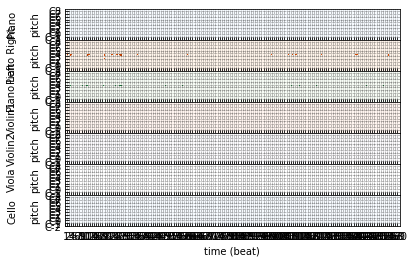

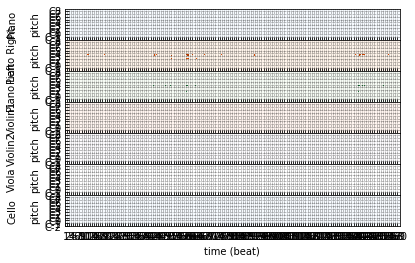

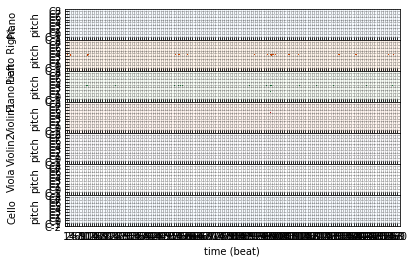

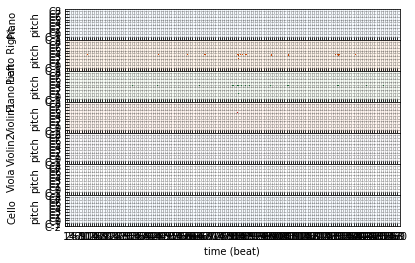

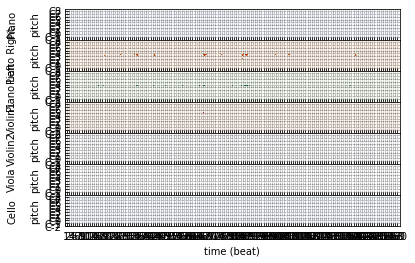

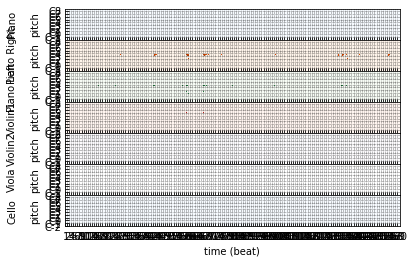

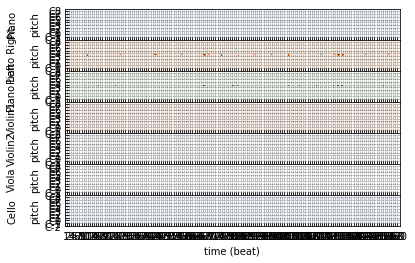

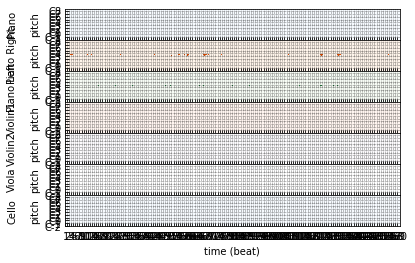

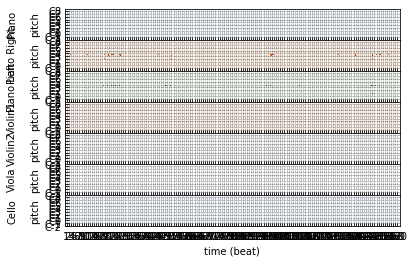

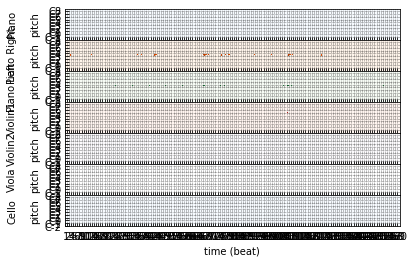

In [9]:
all_checkpoints_path = glob.glob(os.path.join(checkpoint_path, f"wasserloss_gan_all_tracks_checkpoint_gen_7099"))
path = all_checkpoints_path[0]

for i in range(10):
  generated_multitrack = validation(path)
  generated_multitrack.plot()
  pypianoroll.write(os.path.join(validation_path, f'gan_track_{i}.mid'), generated_multitrack)
